In [1]:
# Data
import numpy as np
import pandas as pd
import os
import csv
import xml.etree.ElementTree as ET
import scipy

# Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard

# Imaging
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from tqdm import tqdm
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import pickle

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

In [2]:
from zipfile import ZipFile
file_name = 'data.zip'

if not os.path.isdir("blood-cells"):
    with ZipFile(file_name, 'r') as zip:
        zip.extractall()
        print("Done")

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 507660670900644370, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11912451072782415145
 physical_device_desc: "device: XLA_CPU device"]

In [4]:

# Dicts for classifiers
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

TypeError: Image data cannot be converted to float

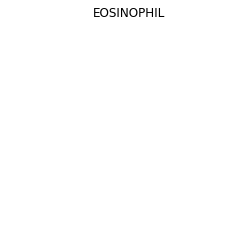

In [5]:
def plotImage(img_dir):
    img = cv2.imread(img_dir)
    plt.imshow(img)


# Demo different cell types
plt.figure(figsize=(8,8))

plt.subplot(221)
image_name = 'blood-cells/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.title('EOSINOPHIL')
plt.axis('off')
plotImage(image_name)

plt.subplot(222)
image_name = 'blood-cells/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.title('LYMPHOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(223)
image_name = 'blood-cells/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.title('MONOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(224)
image_name = 'blood-cells/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('NEUTROPHIL')
plt.axis('off')
plotImage(image_name)

plt.show()

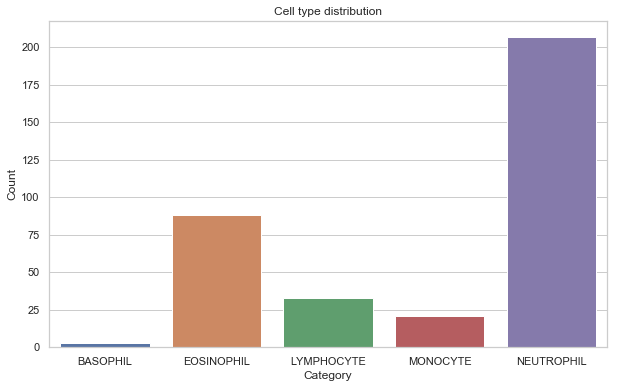

In [6]:
# Data distribution

df = pd.read_csv('blood-cells/dataset2-master/labels.csv')
df = df[['Image','Category']].dropna()
df1 = df[~df.Category.str.contains(",")]
x = df1.groupby('Category').count()

sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x = x.index, y = x['Image'])
ax.set(ylabel = 'Count', title = 'Cell type distribution')

plt.show()

In [7]:
# dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
# dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

from tqdm import tqdm
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical


def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
                
                
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                
                if img_file is not None:
                    img_file = resize(img_file, (60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('blood-cells/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('blood-cells/dataset2-master/images/TEST/')


# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)


# label1 is Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
# Label2 is Mononuclear (Basophil + Lymphocyte + Monocyte) vs Polynuclear (Neutrophil + Eosinophil).

print("\nWe don't really care about basophil anyway.\n")
print(dict_characters)
print(dict_characters2)

  0%|          | 0/2499 [00:00<?, ?it/s]/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 623/623 [00:01<00:00, 374.36it/s]


We don't really care about basophil anyway.

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE', 5: 'BASOPHIL'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [8]:
print("X_train:", X_train.size, "X_train_label", y_train.size)
print("X_train:", X_train.size, "X_train_label", y_trainHot.T.shape)


X_train: 143380800 X_train_label 9957
X_train: 143380800 X_train_label (5, 9957)


80.0


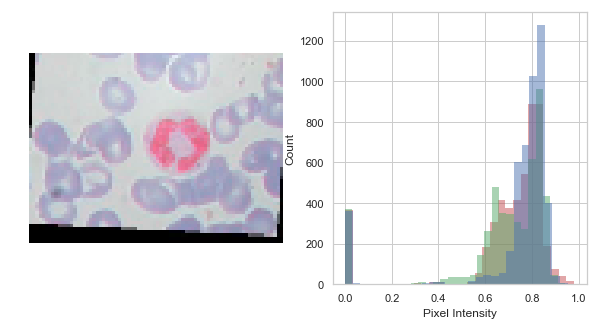

In [9]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


plotHistogram(X_train[1])
print(X_train[1].size/3/60)

In [10]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
# sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

# import time

# dense_layers = [1,2]
# layer_sizes = [32,64,128]
# conv_layers = [1,2,3]

# def build_CNN(x_train, x_label, y_test, y_label, batch_size = 128, epoch = 10):
#     num_category = len(x_label)
#     image_shape = x_train[0].shape
    
    
#     tensorborad = TensorBoard(log_dir='logs/{}'.format("testing"))

#     model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=image_shape))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    
#     model.add(Dense(128))
#     model.add(Activation('relu'))

#     model.add(Dropout(0.5))
#     # model.add(Dense(64))
#     # model.add(Activation('relu'))

#     model.add(Dense(num_category))
#     model.add(Activation('softmax'))



#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# #                 model.fit(x_train, x_label, batch_size=32, epochs = epoch, validation_split=0.3, callbacks=[tensorborad])


#     datagen = ImageDataGenerator(
#                 featurewise_center=False,  # set input mean to 0 over the dataset
#                 samplewise_center=False,  # set each sample mean to 0
#                 featurewise_std_normalization=False,  # divide inputs by std of the dataset
#                 samplewise_std_normalization=False,  # divide each input by its std
#                 zca_whitening=False,  # apply ZCA whitening
#                 rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#                 width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#                 height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#                 horizontal_flip=True,  # randomly flip images
#                 vertical_flip=False) 
#     print(model.summary)

#     model.fit_generator(x_train, x_label,
#                         epochs=epoch, 
#                         validation_data = [y_test, y_label],
#                         callbacks = [tensorborad])

# #     print(model.summary)
                
# ##########################################################################################
# # Command for calling tensorboard: 
# #tensorboard --logdir=logs/ --host localhost --port 8088
# ##########################################################################################

In [14]:
import time
num_category = len(y_trainHot[0])
image_shape = X_train[0].shape

NAME = "logs/{}-{}".format("testing", int(time.time()))

tensorboard = TensorBoard(log_dir=NAME)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=image_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation('relu'))

model.add(Dense(num_category))
model.add(Activation('softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#                 model.fit(x_train, x_label, batch_size=32, epochs = epoch, validation_split=0.3, callbacks=[tensorborad])


datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False) 

history = model.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32),  steps_per_epoch=len(X_train) / 32, epochs= 30)
model.save("model/"+ NAME +' .h5')


# ##########################################################################################
# # Command for calling tensorboard: 
# #tensorboard --logdir=logs/ --host localhost --port 8088
# ##########################################################################################

MemoryError: 

In [ ]:
model.summary()

In [ ]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_testHot)
print("Validation loss", validation_loss)
print("Validation accuracy:",validation_accuracy)


In [ ]:
from tensorflow.keras.models import load_model

# model.save('my_model.h5')
# model = load_model('my_model.h5')
# model.evaluate(X_test, y_testHot)